In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = [5,5]
plt.rcParams['axes.unicode_minus'] = False


dfw = pd.read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/2-1_wine.csv', index_col=0)
dfw.head()

#실습에 사용할 열만 추출
dfw = dfw.filter(['Alcohol', 'Malicacid', 'Ash', 'Magnesium', 'Hue'])

#결측치 삽입
from numpy.random import randint
dfm = dfw.copy()

for col in ['Alcohol', 'Ash']:
    rand_idx = randint(0, len(dfm), 25)
    dfm.loc[rand_idx, col] = np.nan

In [5]:
# -------------------------
# Constant Imputation
# -------------------------
dfm_imp = dfm.fillna(1000)

# -------------------------
# 대표값 Imputation
# -------------------------
from sklearn.impute import SimpleImputer

sImp = SimpleImputer(missing_values=np.nan, strategy='mean')
dfm_imp1 = sImp.fit_transform(dfm)
dfm_imp1 = pd.DataFrame(dfm_imp1, columns=dfm.columns)

print(sImp.statistics_)
dfm_imp1

[13.05910256  2.33634831  2.36701299 99.74157303  0.95744944]


,Alcohol,Malicacid,Ash,Magnesium,Hue
0,14.23,1.71,2.430000,127.0,1.04
1,13.20,1.78,2.367013,100.0,1.05
2,13.16,2.36,2.670000,101.0,1.03
3,14.37,1.95,2.500000,113.0,0.86
4,13.24,2.59,2.870000,118.0,1.04
...,...,...,...,...,...
173,13.71,5.65,2.450000,95.0,0.64
174,13.40,3.91,2.480000,102.0,0.70
175,13.27,4.28,2.260000,120.0,0.59
176,13.17,2.59,2.370000,120.0,0.60


In [6]:
# -------------------------
# 단순확률 대치법
# -------------------------
dfm_imp2 = dfm.copy()

for col in ['Alcohol', 'Ash']:
    miss_idx = dfm[dfm[col].isna()==True].index
    dfm_imp2.loc[miss_idx, col] = df[col].sample(len(miss_idx)).values

dfm_imp2.info()

NameError: name 'df' is not defined

In [ ]:
# -------------------------
# 다른 변수들로 모델링하여 결측값을 예측
# -------------------------
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
dfm_imp3 = imputer.fit_transform(dfm)
dfm_imp3 = pd.DataFrame(dfm_imp3, columns=dfm.columns)
dfm_imp3.isna().sum()

Alcohol      0
Malicacid    0
Ash          0
Magnesium    0
Hue          0
dtype: int64

In [ ]:
# -------------------------
# 보간법(Interpolation)
#   Linear
#       series의 데이터를 하나의 직선 상에 있다고 가정한다.
#   Polynomial
#       series의 데이터를 하나의 다항식 상에 있다고 가정하고, 가장 적합한 다항식을 찾아낸다.
#   Spline (zero:0차, slinear:1차, quadratic:2차, cubic:3차)
#       series의 데이터를 여러 개의 구간의 분할하고 각 구간에 대해, 
#       구간 내 series에 적합하면서 연결점에서 앞뒤 구간에 일치하는 다항식을 찾아낸다.
# -------------------------
dfm_imp4 = dfm.interpolate(method='linear')
dfm_imp4.isna().sum()

Alcohol      0
Malicacid    0
Ash          0
Magnesium    0
Hue          0
dtype: int64

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Alcohol 특성을 기준으로 전처리 성능을 비교
report = pd.DataFrame({
    '실제값':dfw.Alcohol,
    'mean대치':dfm_imp1.Alcohol,
    'Hotdeck':dfm_imp2.Alcohol,
    'KNN대치':dfm_imp3.Alcohol,
    '선형보간':dfm_imp4.Alcohol
})

# 실제값과 대치한 값의 차이를 비교한다.
score_report = pd.DataFrame(index=['MAE', 'MSE'])

for col in report.columns:
    mae = mean_absolute_error(report.실제값, report[col])
    mse = mean_squared_error(report.실제값, report[col])
    score_report.loc['MAE', col] = mae
    score_report.loc['MSE', col] = mse

score_report


,실제값,mean대치,Hotdeck,KNN대치,선형보간
MAE,0.0,0.087651,0.097022,0.073539,0.055674
MSE,0.0,0.082023,0.118611,0.078743,0.032589


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mean radius   569 non-null    float64
 1   mean texture  569 non-null    float64
 2   mean area     569 non-null    float64
 3   target        569 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.9 KB


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.unicode_minus'] = True

wine = pd.read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/refs/heads/main/2-1_wine.csv', index_col=0).filter(['Alcohol', 'Malicacid', 'Ash', 'Magnesium', 'Hue'])
wine.shape

(178, 5)

### 이상치 처리하기

In [ ]:
# ----------------------------------------
# Malicacid 열에서 이상치 찾기 (IQR 방식)
# ----------------------------------------
IQR = wine.Malicacid.quantile(0.75) - wine.Malicacid.quantile(0.25)
top  = wine.Malicacid.quantile(0.75) + IQR*1.5
down = wine.Malicacid.quantile(0.25) - IQR*1.5

out_ids = wine[(wine.Malicacid >= top) | (wine.Malicacid <= down)].index


# ----------------------------------------
# 이상치 처리 전후 Boxplot 시각화 함수 작성
# ----------------------------------------
def ShowBoxplot(df_ori, df_prep):
    fig, axes = plt.subplots(1, 2)
    for data, ax, title in zip([df_ori, df_prep], axes, ['Before', 'After']):
        data.boxplot(ax=ax)
        ax.set_title("{}, ({})".format(title, len(data)))
    plt.show()


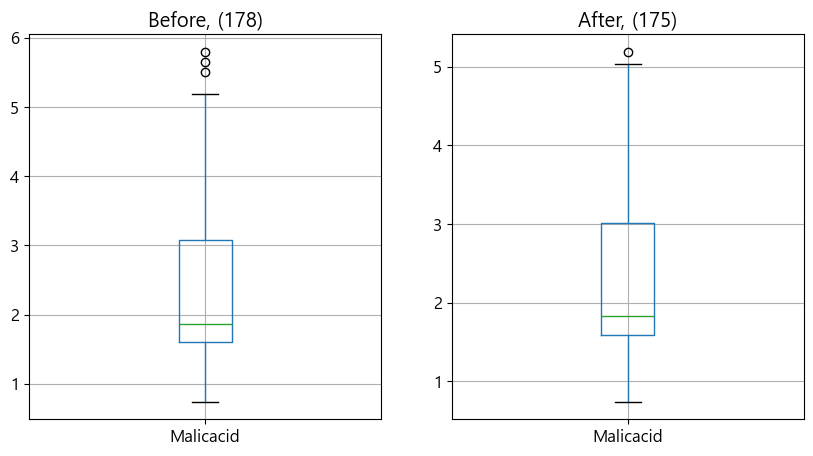

In [ ]:
# ----------------------------------------
# 절단(truncate) 방식 전/후 비교
# ----------------------------------------
df_prep1 = pd.DataFrame(wine.Malicacid.drop(out_ids, axis=0))

ShowBoxplot(wine[['Malicacid']], df_prep1)

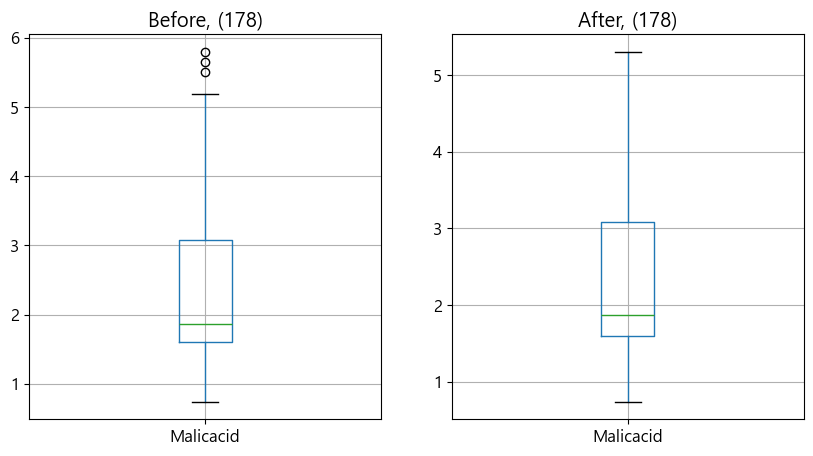

In [ ]:
# ----------------------------------------
# 조정(Winsorizing) 방식 전/후 비교
# ----------------------------------------
df_prep2 = wine[['Malicacid']].clip(top, down)

ShowBoxplot(wine[['Malicacid']], df_prep2)

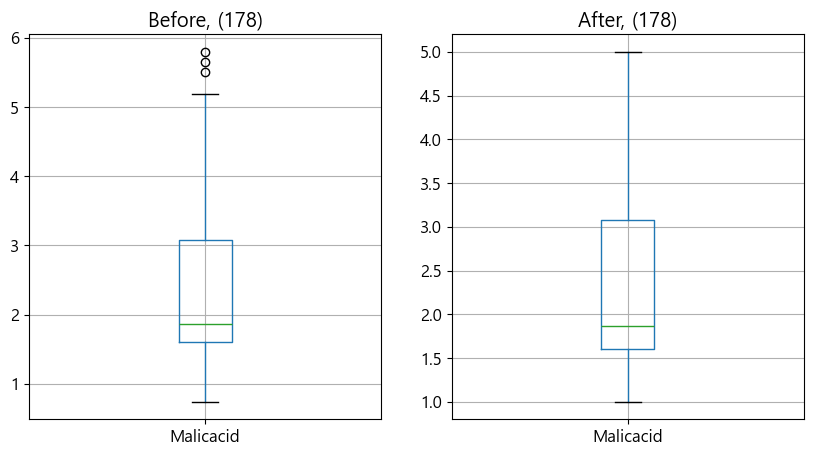

In [ ]:
# ----------------------------------------
# 클리핑(Clipping) 방식 전/후 비교
# ----------------------------------------
df_prep3 = wine[['Malicacid']].clip(5, 1)   # 함수는 동일하게 clip을 쓰는 값을 직접 지정

ShowBoxplot(wine[['Malicacid']], df_prep3)

### 클래스 불균형 처리하기

In [ ]:
from sklearn.datasets import load_breast_cancer
from pandas import concat
from collections import Counter
import seaborn as sns

data = load_breast_cancer()

df = pd.DataFrame(data.data, columns=data.feature_names).filter(['mean radius', 'mean texture', 'mean area', 'target'])
df['target'] = data.target

# 불균형한 imbdf 생성
df1 = df[df.target==0].sample(50)
df2 = df[df.target==1].sample(250)
imbdf = concat([df1, df2]).reset_index(drop=True)

features = imbdf.drop(['target'], axis=1)
target = imbdf.target

def CompareOverSampleMethod(imb_df, os_df):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].set_title('imbalanced')
    sns.scatterplot(x='mean radius', y='mean texture', hue='target', alpha=0.5, style='target', data=imb_df, ax=ax[0], markers={0:'s', 1:'>'})
    ax[1].set_title('oversampled')
    sns.scatterplot(x='mean radius', y='mean texture', hue='target', alpha=0.5, style='target', data=os_df, ax=ax[1], markers={0:'s', 1:'>'})

0      0
1      0
2      0
3      0
4      0
      ..
295    1
296    1
297    1
298    1
299    1
Name: target, Length: 300, dtype: int64

0      0
1      0
2      0
3      0
4      0
      ..
295    1
296    1
297    1
298    1
299    1
Name: target, Length: 300, dtype: int64

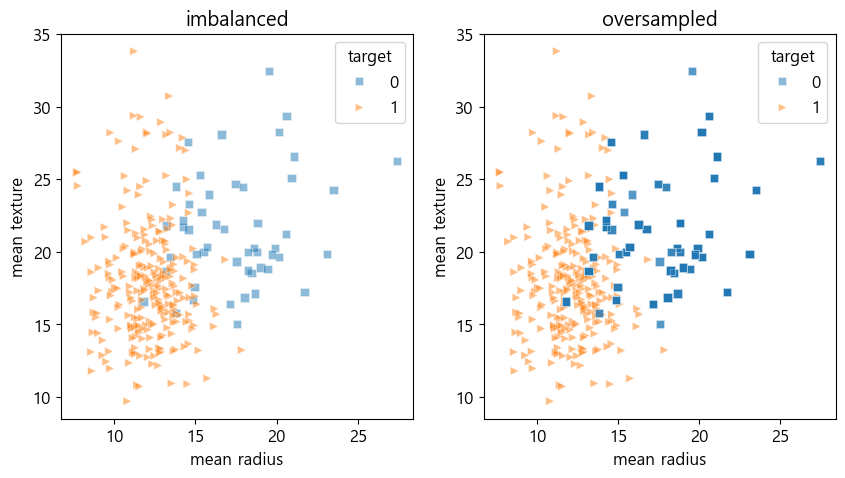

In [ ]:
from imblearn.over_sampling import RandomOverSampler
os = RandomOverSampler(random_state=0)
bal_feat, bal_targ = os.fit_resample(features, target)
over_df1 = concat([bal_feat, bal_targ], axis=1)

CompareOverSampleMethod(imbdf, over_df1)

In [65]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0, k_neighbors=3)
bal_feat, bal_targ = os.fit_resample(features, target)
over_df2 = concat([bal_feat, bal_targ], axis=1)

from imblearn.over_sampling import BorderlineSMOTE

os = BorderlineSMOTE(random_state=0, k_neighbors=3)
bal_feat, bal_targ = os.fit_resample(features, target)
over_df3 = concat([bal_feat, bal_targ], axis=1)

from imblearn.over_sampling import KMeansSMOTE

os = KMeansSMOTE(random_state=0, k_neighbors=3)
bal_feat, bal_targ = os.fit_resample(features, target)
over_df4 = concat([bal_feat, bal_targ], axis=1)


from imblearn.over_sampling import SVMSMOTE

os = SVMSMOTE(random_state=0, k_neighbors=3)
bal_feat, bal_targ = os.fit_resample(features, target)
over_df5 = concat([bal_feat, bal_targ], axis=1)


from imblearn.over_sampling import ADASYN

os = ADASYN(random_state=0, n_neighbors=3)
bal_feat, bal_targ = os.fit_resample(features, target)
over_df6 = concat([bal_feat, bal_targ], axis=1)

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

data = [imbdf, over_df1, over_df2, over_df3 ,over_df4, over_df5, over_df6]
titles=['imbalanced', 'Random', 'SMOTE', 'BorderlineSMOTE', 'KMeansSMOTE', 'SVMSMOTE', 'ADASYN']

scores = pd.DataFrame(index=['train acc', 'test acc', 'train F1', 'test F1'], columns=titles)

for df, title in zip(data, titles):
    feats = df.drop('target', axis=1)
    target = df.target

    X_train, X_test, y_train, y_test = train_test_split(feats, target)

    lr = LogisticRegression(max_iter=300)
    lr.fit(X_train, y_train)

    pred_train = lr.predict(X_train)
    pred_test = lr.predict(X_test)

    scores.loc['train acc', title] = accuracy_score(y_train, pred_train)
    scores.loc['test acc', title] = accuracy_score(y_test, pred_test)
    scores.loc['train f1', title] = f1_score(y_train, pred_train)
    scores.loc['test f1', title] = f1_score(y_test, pred_test)

print(scores)

          imbalanced    Random     SMOTE BorderlineSMOTE KMeansSMOTE  \
train acc   0.942222     0.896  0.893333           0.864    0.970667   
test acc        0.96      0.96     0.904           0.928    0.952381   
train F1         NaN       NaN       NaN             NaN         NaN   
test F1          NaN       NaN       NaN             NaN         NaN   
train f1    0.967089  0.897638  0.896907        0.866142    0.971576   
test f1     0.974359  0.958678       0.9        0.921739    0.951613   

           SVMSMOTE    ADASYN  
train acc  0.909333  0.824468  
test acc      0.896   0.81746  
train F1        NaN       NaN  
test F1         NaN       NaN  
train f1   0.909091  0.830769  
test f1    0.892562  0.813008  
